# Confidence regions of the bivariate $t$-distribution

In this notebook, we demonstrate the function `plot_confregion_bivariate_t()` from `modules.plot_helpers` for plotting $\alpha \times 100\%$ confidence regions of a given bivariate $t$-distribution. No sampling is required to obtain these confidence regions. See the Appendix in our manuscript for the analytic derivation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_t, invwishart
from modules.plot_helpers import plot_confregion_bivariate_t

Let's use some arbitrary bivariate $t$-distribution. Feel free to play with its parameters. We set the argument `validate=True` so that `plot_confregion_bivariate_t()` validates the obtained confidence ellipses. Validation dominates the overall runtime and is not recommended or required in production runs. In practice, we will set `validate=False`.

The parameters `mu`, `Sigma`, and `nu` set the mean vector, scale matrix, and the degree of freedom of the t-distribution, respectively. With `alpha`, we can specify the requested confidence level relative to the normal distribution (if `alpha_unit="normal_std"`) or otherwise as a percentage.

confidence ellipse at level '0.9888910034617577' validated.
confidence ellipse at level '0.8646647167633873' validated.
confidence ellipse at level '0.3934693402873666' validated.


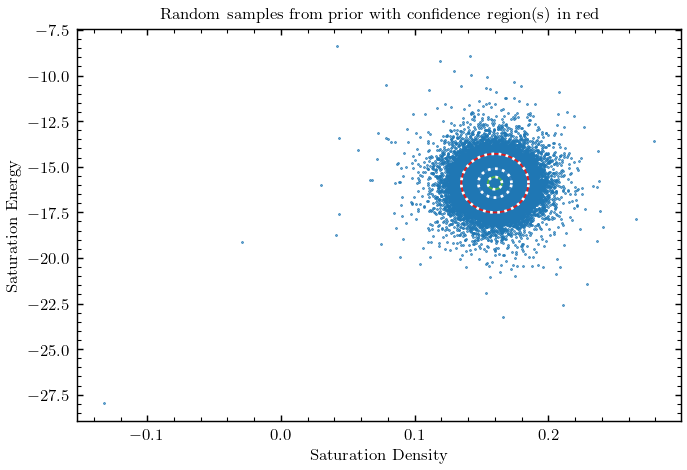

In [2]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.005**2, 0.0], [0.0, 0.32**2]]),
                "kappa": 1, "nu": 5}
fig, ax = plt.subplots(1,1)
plot_confregion_bivariate_t(ax=ax, mu=prior_params["mu"], 
                            Sigma=prior_params["Psi"], nu=prior_params["nu"], 
                            alpha=list(range(1,4)), alpha_unit="normal_std", num_pts=1000000, 
                            plot_scatter=True, validate=True)
ax.set_title("Random samples from prior with confidence region(s) in red")
ax.set_xlabel("Saturation Density")
ax.set_ylabel("Saturation Energy")
plt.savefig("confidence_region_test1.png")

Note that if `num_pts` is chosen too small, the validation may (falsely) fail because the requested tolerance could not have been reached.

Next, let's apply (and validate) the same function for a random symmetric, pos. def. matrix drawn from the Inverse Wishart distribution.

confidence ellipse at level '0.9888910034617577' validated.
confidence ellipse at level '0.8646647167633873' validated.
confidence ellipse at level '0.3934693402873666' validated.


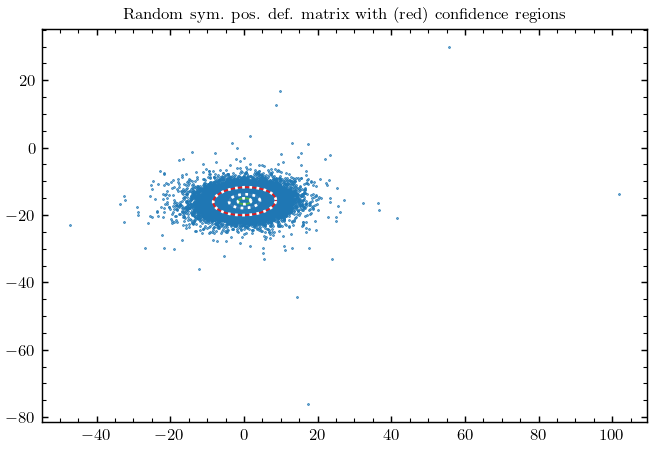

In [3]:
mat = invwishart.rvs(4,np.eye(2)*3)
fig, ax = plt.subplots(1,1)
plot_confregion_bivariate_t(ax=ax, mu=prior_params["mu"], Sigma=mat, 
                            nu=prior_params["nu"], 
                            alpha=list(range(1,4)), alpha_unit="normal_std", num_pts=1000000, 
                            plot_scatter=True, validate=True)
ax.set_title("Random sym. pos. def. matrix with (red) confidence regions")
fig.savefig("prior_satpoint_conf_regions_test2.png")

# Confidence regions of the bivariate Normal distribution

In [4]:
from scipy.stats import multivariate_normal
from modules.plot_helpers import confidence_ellipse
import seaborn as sns

For comparison, let's study the limit `nu` goes to infinity, in which case the t-distribution becomes a normal distribution. First, we sample directly from a multivariate normal distribution:

In [5]:
sx = 0.01
sy = 0.05
rho=0.75
mu=[1,2]
offdiag = sx*sy*rho
Sigma=[[sx**2,offdiag],[offdiag,sy**2]]
data = multivariate_normal.rvs(mean=mu, cov=Sigma, size=10000)

Next, we use our function to plot confidence regions associated with a large-`nu` t-distribution. Here, we choose `nu=10000`. We compare the results with the known confidence ellipse at the 1-sigma level of the normal distribution as well as with a kernel density estimation of the samples we generated above:

<AxesSubplot:>

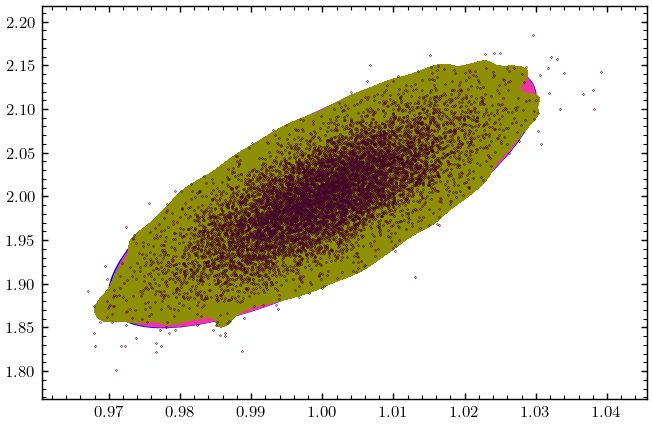

In [6]:
n_std=3
fig, ax = plt.subplots(1,1)
# determine confidence ellipse analytically
plot_confregion_bivariate_t(ax=ax, mu=mu, Sigma=Sigma, 
                            nu=10000, 
                            alpha=n_std, alpha_unit="normal_std", num_pts=100000, 
                            plot_scatter=False, validate=False, edgecolor="b")

# estimate confidence ellipse
confidence_ellipse(ax=ax, x=data[:,0], y=data[:,1], n_std=n_std, show_scatter=True, facecolor='#F034A3')

# use KDE to estimate confidence ellipse
levels = [np.exp(-n_std**2 / 2), 1.]
sns.kdeplot(ax=ax, x=data[:, 0], y=data[:, 1],
            fill=True, levels=levels,
            label=f"",
            legend=False,
            color="y")
#ax.set_xlim(-4,4)
#ax.set_xlim(-4,4)

# Testing marginal distributions of the bivariate $t$ distribution

In this section, we investigate the (two) marginal distributions of the bivariate t-distribution, which are univariate t-distributions with the same degree of freedom.

First, let's generate some samples from the bivariate t-distribution:

In [7]:
import numpy as np
from scipy.stats import multivariate_t
df=5
sig1 = .02
sig2 = .3
offdiag = sig1*sig2*0.9
scale=np.array([[sig1**2,offdiag],[offdiag,sig2**2]])
loc=np.array([0.16, -16.])
data = multivariate_t.rvs(df=df, shape=scale, loc=loc, size=100000000)

Next, let's compute and validate via sampling the two marginal distributions, which are univariate t-distributions (see Sec. II.B in our manuscript):

estimated mu 0.16000111409659407
estimated var 0.0006665477127308064
expected mu 0.16
expected variance 0.0006666666666666668

diff variance -1.6960488499588328e-08
estimated mu -15.999974656574125
estimated var 0.14997893403183063
expected mu -16.0
expected variance 0.15

diff variance -3.3461503115159164e-05


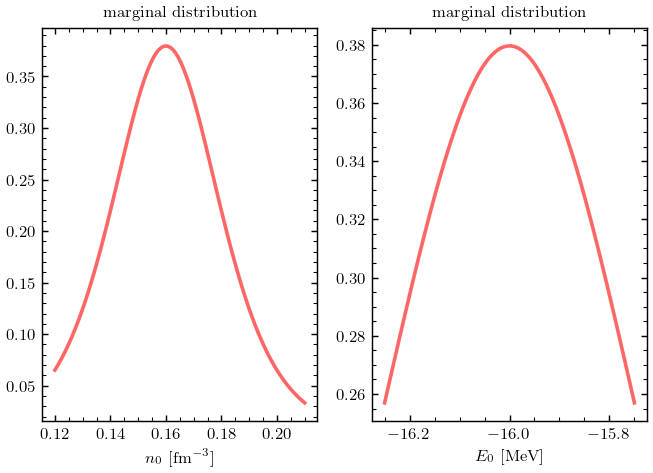

In [8]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
for ind in range(2):
    ax = axs[ind]
    data_mar = data[:, ind]
    print("estimated mu", data_mar.mean())
    print("estimated var", np.var(data_mar))
    sigma_i2 = scale[ind, ind]
    var = df/(df-2) * sigma_i2  # note that sigma is not the covariance matrix of t-dstribution
    print("expected mu", loc[ind])
    print("expected variance", var)
    print("")

    if ind == 0:
        grid = np.linspace(0.12, 0.21, 100)
        ax.set_xlabel("$n_0$ [fm$^{-3}$]")
    else: 
        grid = np.linspace(-16.25, -15.75, 100)
        ax.set_xlabel("$E_0$ [MeV]")

    ax.set_title("marginal distribution")

    sigma = [sig1, sig2][ind]  #  0.02
    # df=5
    y = t.pdf(grid, df=df, loc=loc[ind], scale=sigma)
    ax.plot(grid, y*sigma, 'r-', lw=2, alpha=0.6, label='t pdf')
    samples = t.rvs(size=100000000, df=df, loc=loc[ind], scale=sigma)
    print("diff variance", np.var(samples) * (df-2)/df - sigma**2)